# 5.1

In [3]:
from __future__ import print_function, division
%matplotlib inline
import thinkdsp
import thinkplot
import thinkstats2
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
PI2 = np.pi * 2

Возьмем методы из chap05.ipynb

In [4]:
def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2, ddof=0)[0, 1]
    return corr

In [5]:
def autocorr(wave):
    lags = range(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

Возьмем звук из репозитория:

In [6]:
wave = thinkdsp.read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

Выделим короткий сегмент 

In [13]:
segment = wave.segment(start=0.25, duration=0.01)

Применим автокорреляционную функцию, чтобы оценить высоту тона:

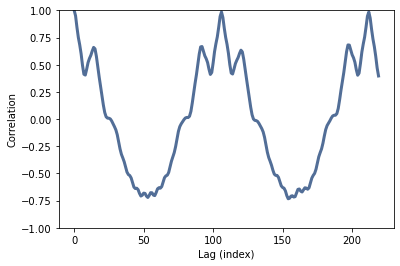

In [14]:
lags, corrs = autocorr(segment)
thinkplot.plot(lags, corrs)
thinkplot.config(xlabel='Lag (index)', ylabel='Correlation', ylim=[-1, 1])

Пик ∈ [100;150]. Используем argmax, чтобы уточнить значение для этого пика

In [15]:
low, high = 100, 150
lag = np.array(corrs[low:high]).argmax() + low
lag

106

Вычислим частоту для этого значения:

In [16]:
period = lag / segment.framerate
frequency = 1 / period
frequency

416.0377358490566

Возьмем другой сегмент и проделаем те же действия:

In [17]:
segment = wave.segment(start=0.75, duration=0.01)

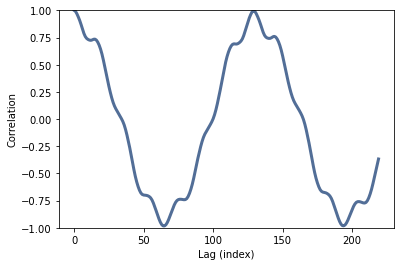

In [18]:
lags, corrs = autocorr(segment)
thinkplot.plot(lags, corrs)
thinkplot.config(xlabel='Lag (index)', ylabel='Correlation', ylim=[-1, 1])

Пик ∈ [100;150]. Используем argmax, чтобы уточнить значение для этого пика

In [19]:
low, high = 100, 150
lag = np.array(corrs[low:high]).argmax() + low
lag

129

Вычислим частоту:

In [20]:
period = lag / segment.framerate
frequency = 1 / period
frequency

341.86046511627904

Делаем вывод, что частота обратно пропорциональна времени начала сегмента

# 5.2

Используем тот же звук, что и в 5.1

In [21]:
wave = thinkdsp.read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

Отобразим спектрограмму:

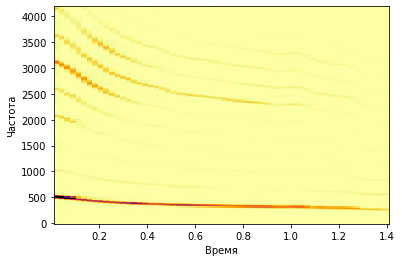

In [22]:
wave.make_spectrogram(2048).plot(high=4200)
thinkplot.config(xlabel='Время', ylabel='Частота')

Упростим задачу, указав диапазон Lag для поиска, так как найти самый первый высокий пик достаточно сложно.

In [23]:
from autocorr import autocorr
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Рассмотрим пример использования этой функции:

In [24]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

Используем функцию для отслеживания высоты звука по сэмплу. Ts - это средние точки каждого сегмента.

In [25]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Вот кривая для отслеживания высоты тона, наложенная на спектрограмму:

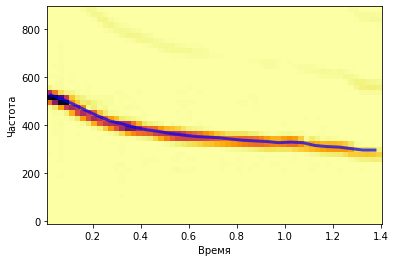

In [26]:
wave.make_spectrogram(2048).plot(high=900)
thinkplot.plot(ts, freqs, color='blue')
thinkplot.config(xlabel='Время', ylabel='Частота')

# 5.3

In [27]:
data_bit = pd.read_csv('bit.csv')
data_bit

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2354,BTC,2020-03-22,5884.340133,6187.042146,6431.873162,5802.553402
2355,BTC,2020-03-23,6455.454688,5829.352511,6620.858253,5694.198299
2356,BTC,2020-03-24,6784.318011,6455.450650,6863.602196,6406.037439
2357,BTC,2020-03-25,6706.985089,6784.325204,6981.720386,6488.111885


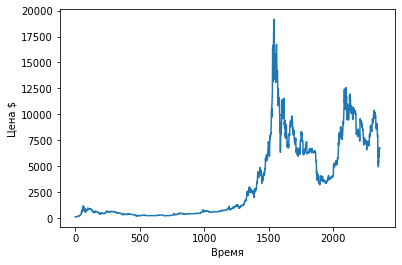

In [29]:
wave = thinkdsp.Wave(data_bit['Closing Price (USD)'], data_bit.index, framerate=1)
wave.plot()
thinkplot.config(xlabel='Время', ylabel='Цена $')

Применим функцию автокорреляции:

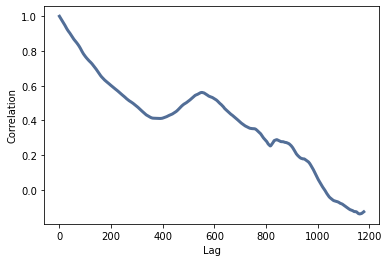

In [30]:
from autocorr import autocorr

lags, corrs = autocorr(wave)
thinkplot.plot(lags, corrs)
thinkplot.config(xlabel='Lag', ylabel='Correlation')

Функция медленно снижается по мере увеличения задержки, что указывает на какой-то розовый шум.

Мы можем сравнить autocorr с np.correlate, в котором используется определение корреляции, используемое при обработке сигналов. Он не устраняет предвзятость, нормализует и не стандартизирует волну.

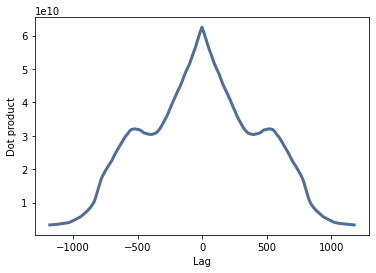

In [31]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
thinkplot.plot(lags, corrs2)
thinkplot.config(xlabel='Lag', ylabel='Dot product')

Вторая половина результата соответствует положительным Lags:

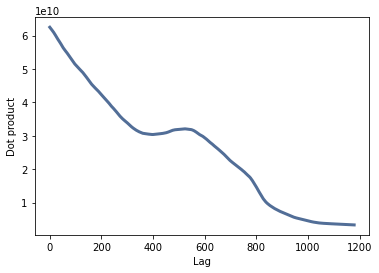

In [32]:
N = len(corrs2)
half = corrs2[N//2:]
thinkplot.plot(half)
thinkplot.config(xlabel='Lag', ylabel='Dot product')

Нормализуем результаты постфактум, разделив их по длине:

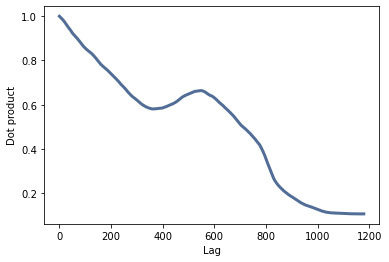

In [33]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
thinkplot.plot(half)
thinkplot.config(xlabel='Lag', ylabel='Dot product')

In [35]:
# Сравним полученные результаты:

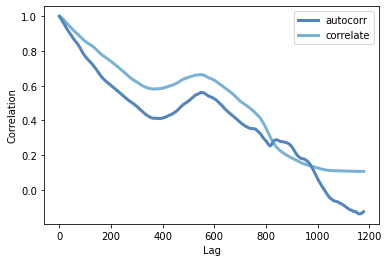

In [36]:
thinkplot.preplot(2)
thinkplot.plot(corrs, label='autocorr')
thinkplot.plot(half, label='correlate')
thinkplot.config(xlabel='Lag', ylabel='Correlation')

Даже после стандартизации результаты выглядят существенно иначе.

Для этого набора данных, вероятно, более подходящим является статистическое определение ACF.

# 5.4

In [37]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interact, fixed
from IPython.html import widgets

PI2 = np.pi * 2

%matplotlib inline

Возьму звук саксофона предложенный учебником:

In [39]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.normalize()
wave.make_audio()

Спектрограмма показывает гармоническую структуру во времени.

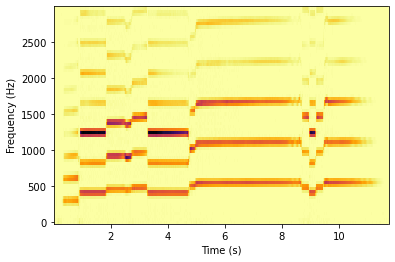

In [40]:
spectrogram = wave.make_spectrogram(seg_length=1024)
spectrogram.plot(high=3000)
thinkplot.config(xlabel='Time (s)', ylabel='Frequency (Hz)')

Выберем сегмент, чтобы лучше увидеть гармоники:

In [46]:
start = 5.0
duration = 0.5
segment = wave.segment(start=start, duration=duration)
segment.make_audio()

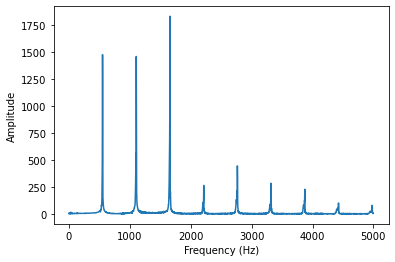

In [47]:
spectrum = segment.make_spectrum()
spectrum.plot(high=5000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Пики в спектре находятся на частотах 1660, 552 и 1106 Гц.

In [49]:
spectrum.peaks()[:10]

[(1830.7954217194178, 1660.0),
 (1474.6770429023884, 552.0),
 (1458.236548667378, 1106.0),
 (1272.1047060277945, 554.0),
 (916.0060465658285, 1108.0),
 (911.9888001220569, 1656.0),
 (850.7712819825957, 550.0),
 (796.9896024643556, 1658.0),
 (746.615815912369, 1662.0),
 (681.7277437201905, 1654.0)]

Высота, которую мы воспринимаем, является основной, 552 Гц, хотя это не доминирующая частота.

Для сравнения, вот треугольная волна на частоте 552 Гц.

In [51]:
thinkdsp.TriangleSignal(freq=552).make_wave(duration=0.5).make_audio()

In [52]:
segment.make_audio()

У них одинаковая воспринимаемая высота звука.

Чтобы понять, почему мы воспринимаем основную частоту, даже если она не является доминирующей, полезно взглянуть на функцию автокорреляции (ACF).

Следующая функция вычисляет ACF, выбирает вторую половину (которая соответствует положительным задержкам) и нормализует результаты:

In [53]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

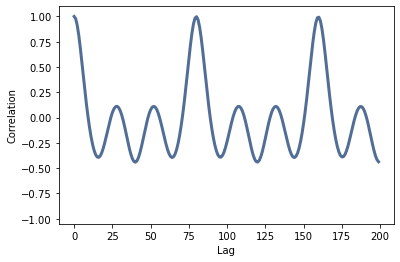

In [54]:
corrs = autocorr(segment)
thinkplot.plot(corrs[:200])
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.10])

Первый главный пик находится рядом с лагом 100.

Следующая функция находит самую высокую корреляцию в заданном диапазоне задержек и возвращает соответствующую частоту.

In [55]:
def find_frequency(corrs, low, high):
    lag = np.array(corrs[low:high]).argmax() + low
    print(lag)
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

In [56]:
find_frequency(corrs, 80, 100)

80


551.25

Наибольший пик приходится на lag 95, что соответствует частоте 551.25 Гц.
По крайней мере, в этом примере высота звука, которую мы воспринимаем, соответствует наивысшему пику автокорреляционной функции (ACF), а не самому высокому компоненту спектра.
Удивительно, но воспринимаемый шаг не меняется, если мы полностью удаляем фундаментальный. Вот как выглядит спектр, если мы используем фильтр высоких частот, чтобы убрать фундаментальный.

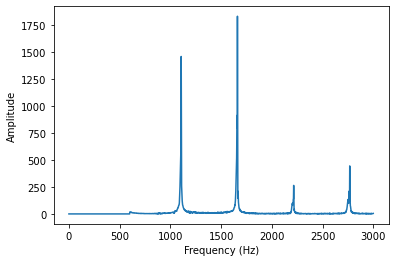

In [57]:
spectrum2 = segment.make_spectrum()
spectrum2.high_pass(600)
spectrum2.plot(high=3000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Создадим звук:

In [58]:
segment2 = spectrum2.make_wave()
segment2.make_audio()

Воспринимаемая высота звука по-прежнему составляет 552 Гц, хотя на этой частоте нет мощности.

Чтобы понять, почему мы слышим частоту, которой нет в сигнале, полезно взглянуть на функцию автокорреляции (ACF).

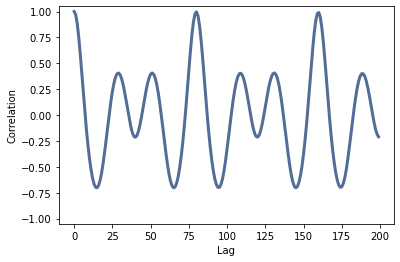

In [59]:
corrs = autocorr(segment2)
thinkplot.plot(corrs[:200])
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

Третий пик, соответствующий 552 Гц, по-прежнему самый высокий:

In [60]:
find_frequency(corrs, 80, 100)

80


551.25

In [61]:
find_frequency(corrs, 20, 50)

29


1520.6896551724137

In [62]:
find_frequency(corrs, 50, 80)

79


558.2278481012657

Остальные пики не являются гармониками.

Наше ухо интерпретирует высокие гармоники как свидетельство того, что "правильный" фундаментал находится на частоте 552 Гц.

Если мы избавимся от высоких гармоник, эффект исчезнет. Рассмотрим спектр с удалёнными гармониками выше 1200 Гц.

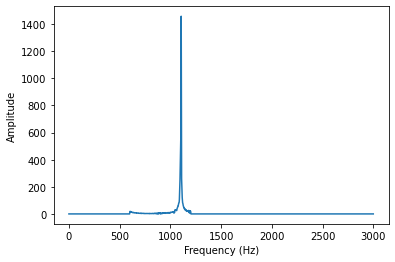

In [63]:
spectrum4 = segment.make_spectrum()
spectrum4.high_pass(600)
spectrum4.low_pass(1200)
spectrum4.plot(high=3000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [64]:
segment4 = spectrum4.make_wave()
segment4.make_audio()

Сейчас воспринимается частота примерно равная 1100Гц.
Создадим треугольный сигнал:

In [65]:
thinkdsp.TriangleSignal(freq=1100).make_wave(duration=0.5).make_audio()

In [66]:
# И если мы посмотрим на функцию автокорреляции, мы найдем самый высокий пик при лаге = 40, что соответствует 1102 Гц.

SyntaxError: invalid syntax (<ipython-input-66-c3b4d60a61ca>, line 1)

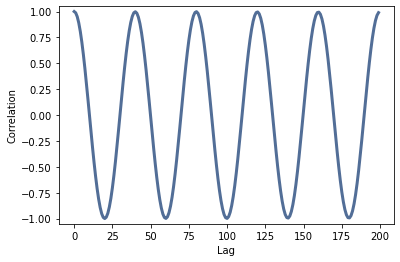

In [67]:
corrs = autocorr(segment4)
thinkplot.plot(corrs[:200])
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

In [68]:
find_frequency(corrs, 30, 50)

40


1102.5

Выведем все звуки для удобного сравнения:

Треугольный сигнал на частоте 552Гц:

In [69]:
thinkdsp.TriangleSignal(freq=552).make_wave(duration=0.5).make_audio()

Изначально созданный сегмент:

In [70]:
segment.make_audio()

Сигнал, который появился после основного пика:

In [71]:
segment2.make_audio()

Сигнал, который пояился после удаления гармоник выше основного пика:

In [72]:
segment4.make_audio()

Чистый синусоидный сигнал

In [75]:
thinkdsp.SinSignal(freq=1102).make_wave(duration=0.5).make_audio()

Таким образом, эти эксперименты предполагают, что восприятие высоты звука не полностью основано на спектральном анализе, но также определяется чем-то вроде автокорреляции.